In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
class BrainTumorDataset(Dataset):
    def __init__(self, image_mask_pairs, transform=None):
        self.image_mask_pairs = image_mask_pairs
        self.transform = transform

    def __len__(self):
        return len(self.image_mask_pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.image_mask_pairs[idx]

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        image = cv2.resize(image, (256, 256))
        mask = cv2.resize(mask, (256, 256))

        image = np.stack([image, image, image], axis=-1)
        mask = (mask > 0).astype(np.uint8)

        if self.transform:
            image = self.transform(image)

        mask = torch.tensor(mask, dtype=torch.long)
        return image, mask

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mateuszbuda/lgg-mri-segmentation")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/mateuszbuda/lgg-mri-segmentation/versions/2


In [4]:
dataset_path = "/root/.cache/kagglehub/datasets/mateuszbuda/lgg-mri-segmentation/versions/2/kaggle_3m"
pairs = []

for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    if not os.path.isdir(folder_path):
        continue

    for file in os.listdir(folder_path):
        if file.endswith(".tif") and "_mask" not in file:
            img_path = os.path.join(folder_path, file)
            mask_path = img_path.replace(".tif", "_mask.tif")

            if os.path.exists(mask_path):
                pairs.append((img_path, mask_path))

In [5]:
train_pairs, val_pairs = train_test_split(pairs, test_size=0.2, random_state=42)

transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5],
                std=[0.5, 0.5, 0.5])
])

In [6]:
train_dataset = BrainTumorDataset(train_pairs, transform)
val_dataset = BrainTumorDataset(val_pairs, transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)

In [7]:
from torchvision.models.segmentation import fcn_resnet50
import torch.nn as nn

model = fcn_resnet50(pretrained=True)

model.classifier = nn.Sequential(
    nn.Conv2d(2048, 2, kernel_size=1)
)

model.aux_classifier = None

model = model.cuda()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
import torch.nn.functional as F

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

In [9]:
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, masks in train_loader:
        images = images.cuda()
        masks = masks.cuda()

        outputs = model(images)['out']
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")

Epoch [1/3], Loss: 0.0257
Epoch [2/3], Loss: 0.0101
Epoch [3/3], Loss: 0.0079


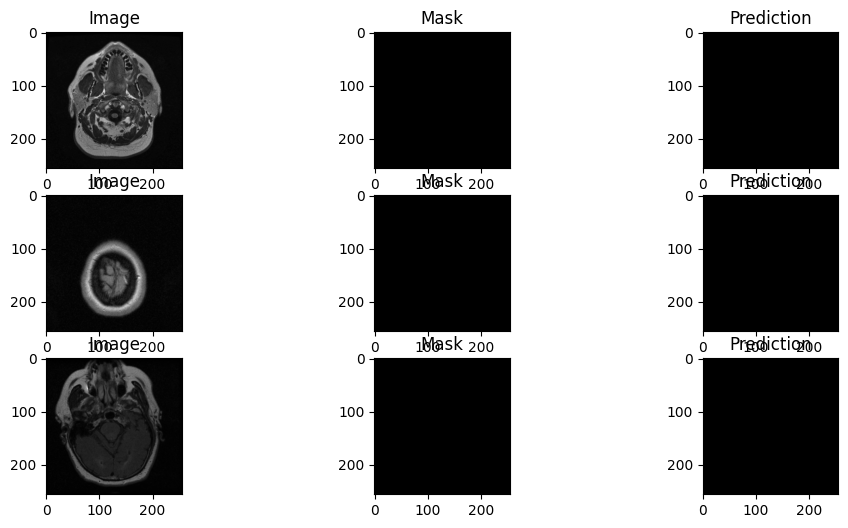

In [10]:
model.eval()

with torch.no_grad():
    images, masks = next(iter(val_loader))
    images = images.cuda()

    outputs = model(images)['out']
    preds = torch.argmax(outputs, dim=1).cpu()

plt.figure(figsize=(12, 6))
for i in range(3):
    plt.subplot(3, 3, i*3 + 1)
    plt.imshow(images[i][0].cpu(), cmap='gray')
    plt.title("Image")

    plt.subplot(3, 3, i*3 + 2)
    plt.imshow(masks[i], cmap='gray')
    plt.title("Mask")

    plt.subplot(3, 3, i*3 + 3)
    plt.imshow(preds[i], cmap='gray')
    plt.title("Prediction")

plt.savefig("output.png")
plt.show()

In [11]:
def dice_score(pred, target):
    smooth = 1e-6
    pred = pred.flatten()
    target = target.flatten()
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

In [12]:
total_dice = 0

with torch.no_grad():
    for images, masks in val_loader:
        images = images.cuda()
        outputs = model(images)['out']
        preds = torch.argmax(outputs, dim=1).cpu()

        total_dice += dice_score(preds, masks)

print("Average Dice Score:", total_dice / len(val_loader))

Average Dice Score: tensor(0.7515)
